In [148]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup

In [149]:
spam_1_path = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
spam_2_path = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
nonspam_1_path = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
nonspam_2_path = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'
spam_cat =1 
ham_cat =0
data_json_file='SpamData/01_Processing/email-text-data.json'

In [150]:
#Reading files
eg_file = 'SpamData/01_Processing/practice_email.txt'
stream=open(eg_file,encoding="latin-1")
message=stream.read()
stream.close()

In [151]:
stream=open(eg_file)
is_body=False
lines=[]
for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True
stream.close()
email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Creating Pandas DataFrame of email bodies

In [152]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body


In [153]:
def df_from_directory(path,classification):
    rows=[]
    rows_names=[]
    for file_names,email_body in email_body_generator(path):
        rows.append({'MESSAGE':email_body, 'CATEGORY':classification})
        rows_names.append(file_names)
    return pd.DataFrame(rows,index=rows_names)

In [154]:
#for spam emails
spam_emails = df_from_directory(spam_1_path,spam_cat)
spam_emails = pd.concat([spam_emails,df_from_directory(spam_2_path,spam_cat)])
print(spam_emails.shape)

(1898, 2)


In [155]:
#for non-spam emails
ham_emails = df_from_directory(nonspam_1_path,ham_cat)
ham_emails = pd.concat([ham_emails, df_from_directory(nonspam_2_path,ham_cat)])
print(ham_emails.shape)

(3901, 2)


In [156]:
#concating both spam and non-emails
data = pd.concat([spam_emails,ham_emails])
print('shape of the whole dataframe',data.shape)

shape of the whole dataframe (5799, 2)


## Data Cleaning: checking for missing values

In [157]:
# null_string =""
# none_string =None
# print(type(null_string))
# print(type(none_string))

In [158]:
#checking none values
print((data.MESSAGE.str.len()==0).values.any())
print((data.MESSAGE.str.len()==0).sum())
#checking null values
print(data.MESSAGE.isnull().values.any())
print(data.MESSAGE.isnull().sum())

True
3
False
0


In [159]:
# data.MESSAGE.str.len()
print(data.shape)
print(type(data))

(5799, 2)
<class 'pandas.core.frame.DataFrame'>


In [160]:
type(data.MESSAGE.str.len()==0)
print(data[data.MESSAGE.str.len()==0].index)

Index(['cmds', 'cmds', 'cmds'], dtype='object')


In [161]:
#Adding Document IDs to track Email in dataset
document_ids=range(0,len(data.index))
data['DOC_ID']=document_ids
data['FILENAME']=data.index
data.set_index('DOC_ID',inplace=True)
data.head()

,MESSAGE,CATEGORY,FILENAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [162]:
data.tail()

,MESSAGE,CATEGORY,FILENAME
DOC_ID,,,
5794,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5795,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5796,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5797,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5798,"Hi there,\n\n\n\nNow this is probably of no us...",0,01400.f897f0931e461e7b2e964d28e927c35e


In [163]:
#Saving Files as json
data.to_json(data_json_file)

# Data Visualization

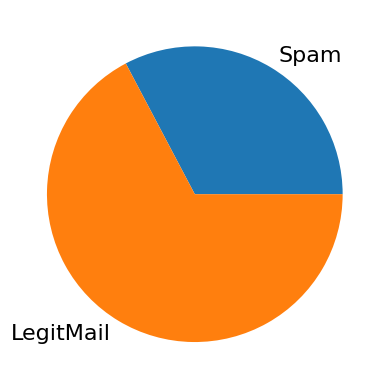

In [164]:
#Number of Spam Messages Visualised (Pie Charts)
data.CATEGORY.value_counts()
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]
category_names = ['Spam','LegitMail']
sizes = [amount_of_spam, amount_of_ham]
plt.pie(x=sizes,labels=category_names,textprops={'fontsize':16})
plt.show()

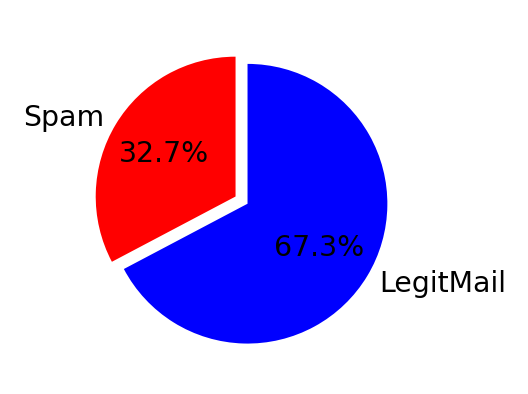

In [165]:
#Number of Spam Messages Visualised (Pie Charts)
data.CATEGORY.value_counts()
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]
category_names = ['Spam','LegitMail']
colours=['red','blue']
explode=[0,0.1]
sizes = [amount_of_spam, amount_of_ham]
plt.figure(figsize=(2,2),dpi=227)
plt.pie(x=sizes,labels=category_names,textprops={'fontsize':9},colors=colours,explode=[0,0.1],autopct ='%1.1f%%',startangle=90)
plt.show()

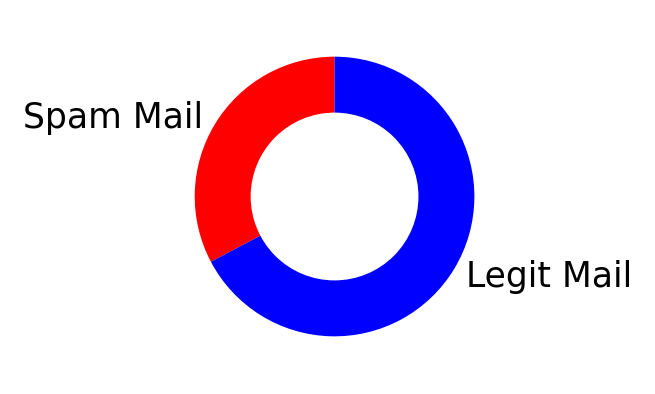

In [166]:
#Donought Chart
#Drawing Circle
category_names = ['Spam Mail','Legit Mail']
colours=['red','blue']
explode=[0,0]
sizes = [amount_of_spam, amount_of_ham]
plt.figure(figsize=(2,2),dpi=227)
plt.pie(x=sizes,labels=category_names,textprops={'fontsize':11},colors=colours,explode=explode,startangle=90)
#autopct ='%1.1f%%'
center_circle = plt.Circle((0,0),radius=0.6,fc='white')
plt.gca().add_artist(center_circle)
plt.show()

# Natural Language Processing

In [167]:
#Downloading the NLTK Resources (Tokenizer and Stopwords)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aadit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aadit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [168]:
#Tokenzing
msg='All work and no play makes Jack a dull boy'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy']

In [169]:
#Removing Stop word
stop_words = set(stopwords.words('english'))
if 'this' in stop_words:
    print ('Found it')
if 'hello' not in stop_words:
    print ('Not here')

Found it
Not here


In [170]:
#Testing with msg,
words = word_tokenize(msg.lower())
filtered_words=[]
for word in words:
    if word not in stop_words:
        filtered_words.append(word)

print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy']


# Word stemming and Removing puntuations

In [171]:
#we add stemmer to previous code

words = word_tokenize(msg.lower())
filtered_words=[]
stemmer = PorterStemmer()
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy']


In [172]:
#checking if alphabet or not
print('a'.isalpha())
print('?'.isalpha())

True
False


In [173]:
#Removing HTML tags from Emails
soup = BeautifulSoup(data.at[5,'MESSAGE'],'html.parser')
# print(soup.prettify())
# soup.get_text()

In [174]:
# print(data.at[2,'MESSAGE'])

In [175]:
#function for email processing 
def clean_msg(message,stop_word=set(stopwords.words('english'))):
    stemmer=PorterStemmer()
    #Removing HTML TAGS
    soup = BeautifulSoup(message,'html.parser')
    cleaned_text = soup.get_text()
    #Conversts to lowercase and splits the words
    words = word_tokenize(cleaned_text.lower())
    filtered_words=[]
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    return filtered_words

In [176]:
print(clean_msg(data.at[2,'MESSAGE']))

['fight', 'risk', 'cancer', 'http', 'slim', 'guarante', 'lose', 'lb', 'day', 'http', 'get', 'child', 'support', 'deserv', 'free', 'legal', 'advic', 'http', 'join', 'web', 'fastest', 'grow', 'singl', 'commun', 'http', 'start', 'privat', 'photo', 'album', 'onlin', 'http', 'wonder', 'day', 'offer', 'manag', 'prizemama', 'wish', 'leav', 'list', 'pleas', 'use', 'link', 'http', 'zzzz']


In [191]:
#Applying cleaning and Tokenization to all messages
first_emails = data.MESSAGE.iloc[0:3]
first_emails_list = first_emails.apply(clean_msg)

In [190]:
first_emails_list[0]

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email']

In [193]:
the_list=data.MESSAGE.apply(clean_msg)

## Using logic to slice DataFrames

In [194]:
print("Spam Messages => ",data[data.CATEGORY == 1].shape)
print("Ham Messages => ",data[data.CATEGORY == 0].shape)

Spam Messages =>  (1898, 3)
Ham Messages =>  (3901, 3)


In [195]:
doc_ids_spam = data[data.CATEGORY ==1].index
doc_ids_ham = data[data.CATEGORY ==0].index

In [196]:
#Subsetting a Series with an Index
print(type(doc_ids_ham))
type(the_list)

<class 'pandas.core.indexes.numeric.Int64Index'>


pandas.core.series.Series

In [197]:
#Storing Indicies for spam / non-spam emails in variables
doc_ids_spam = data[data.CATEGORY==1].index
doc_ids_ham = data[data.CATEGORY== 0].index

In [198]:
#Subsetting a Series with an index
print(doc_ids_ham)
print(the_list.tail)

Int64Index([1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907,
            ...
            5789, 5790, 5791, 5792, 5793, 5794, 5795, 5796, 5797, 5798],
           dtype='int64', name='DOC_ID', length=3901)
<bound method NDFrame.tail of DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5794    [http, bizarr, collect, stuf, anim, could, fet...
5795    [care, use, one, also, realli, cute, thing, ja...
5796    [sm, skip, montanaro, write, jeremi, put, anot...
5797    [mark, hammond, like, given, zodb, sound, attr...
5798    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5799, dtype: object>


In [200]:
the_list_ham = the_list.loc[doc_ids_ham]
print(the_list_ham.shape)
print(the_list_ham.tail())

(3901,)
DOC_ID
5794    [http, bizarr, collect, stuf, anim, could, fet...
5795    [care, use, one, also, realli, cute, thing, ja...
5796    [sm, skip, montanaro, write, jeremi, put, anot...
5797    [mark, hammond, like, given, zodb, sound, attr...
5798    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object


In [203]:
the_list_spam = the_list.loc[doc_ids_spam]
print(the_list_spam.shape)
print(the_list_spam.tail())

(1898,)
DOC_ID
1893    [messag, mime, format, prefer, doctor, order, ...
1894    [dear, subscrib, could, show, way, get, visito...
1895    [custom, appreci, sale, express, appreci, loya...
1896    [attn, strictli, confidenti, pleas, introduc, ...
1897                                                   []
Name: MESSAGE, dtype: object


### Finding most common words in both types of Mail

In [214]:
flat_list_ham =[item for sublist in the_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()
print(normal_words.shape[0]) #total number of ham words
print(normal_words[:10])

20815
http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64


In [215]:
flat_list_spam =[item for sublist in the_list_spam for item in sublist]
spam_words = pd.Series(flat_list_spam).value_counts()
print(spam_words.shape[0]) #total number of ham words
print(spam_words[:10])

13242
http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64
